In [137]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf

### Remove "Bad" Images from Dataset

In [138]:
import cv2
import imghdr

# path to data directory
data_dir = 'data'

# image extensions we want our model to use
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# remove dodgy images
for image_class in os.listdir(data_dir):                            # loop through cats and dogs data directories
    for image in os.listdir(os.path.join(data_dir, image_class)):   # loop through every image in respective directory
        image_path = os.path.join(data_dir, image_class, image)    
        try:                                                        # remove any images without specified extensions
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

### Generate Batches of Data

Found 480 files belonging to 2 classes.


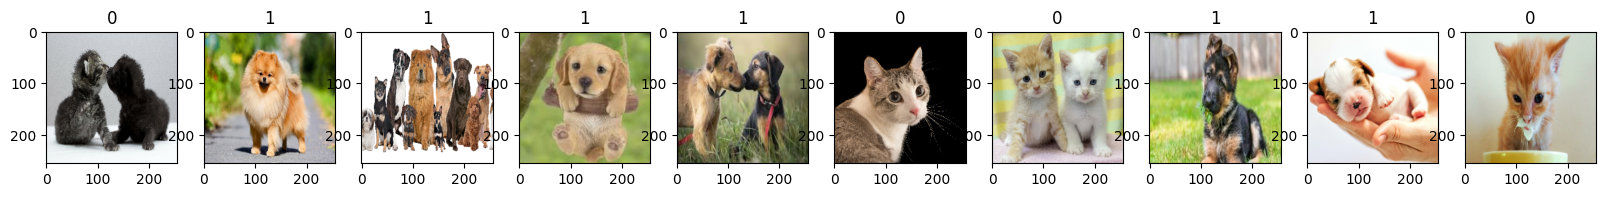

In [139]:
from matplotlib import pyplot as plt

# load and shuffle data
data = tf.keras.utils.image_dataset_from_directory('data')
data = data.shuffle(buffer_size = data.cardinality(), reshuffle_each_iteration = False)
data_iterator = data.as_numpy_iterator()

# get batch of 32 images from iterator
batch = data_iterator.next()

# plot a few images from dataset
fig, ax = plt.subplots(ncols = 10, figsize = (20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 1 signifies a picture of a dog
# 0 signifies a picture of a cat

### Preprocessing Dataset

In [140]:
# scale data
data = data.map(lambda x, y: (x/255, y))

data.as_numpy_iterator().next()

(array([[[[0.8141343 , 0.8651147 , 0.8981723 ],
          [0.8090083 , 0.8654402 , 0.89457625],
          [0.79964095, 0.8676949 , 0.89241534],
          ...,
          [0.6246802 , 0.6975576 , 0.7491948 ],
          [0.61344975, 0.69825655, 0.7470933 ],
          [0.624122  , 0.69123775, 0.7489162 ]],
 
         [[0.812747  , 0.8650735 , 0.895773  ],
          [0.8105172 , 0.8670736 , 0.8959061 ],
          [0.81783086, 0.8709186 , 0.9019091 ],
          ...,
          [0.62757355, 0.70183825, 0.7596862 ],
          [0.63173443, 0.6993317 , 0.7501532 ],
          [0.6188725 , 0.69185144, 0.7449736 ]],
 
         [[0.810364  , 0.86554646, 0.89256376],
          [0.80397326, 0.8697304 , 0.8979119 ],
          [0.8109375 , 0.8659984 , 0.9010474 ],
          ...,
          [0.62517136, 0.7012063 , 0.7469669 ],
          [0.6225088 , 0.6961608 , 0.75106275],
          [0.6168505 , 0.6909055 , 0.74912876]],
 
         ...,
 
         [[0.99004674, 0.96819854, 0.88956994],
          [0.99000

In [141]:
# get sizes of splits
train_size = int(len(data) * .7)        # used to train model
validation_size = int(len(data) * .2)   # used for post-training evaluation
test_size = int(len(data) * .1) + 1     # final evaluation for model

# split data
train = data.take(train_size)
val = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

### Creating a Deep-Learning Model

In [142]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# creating deep learning model
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train Deep-Learning Model

In [143]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
hist = model.fit(train, epochs = 11, validation_data = val, callbacks = [tensorboard_callback], shuffle = False)

Epoch 1/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 846ms/step - accuracy: 0.5209 - loss: 1.4371 - val_accuracy: 0.4688 - val_loss: 0.6918
Epoch 2/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 850ms/step - accuracy: 0.5265 - loss: 0.6904 - val_accuracy: 0.6146 - val_loss: 0.6771
Epoch 3/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 850ms/step - accuracy: 0.5873 - loss: 0.6756 - val_accuracy: 0.7083 - val_loss: 0.6305
Epoch 4/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 858ms/step - accuracy: 0.6959 - loss: 0.6110 - val_accuracy: 0.7812 - val_loss: 0.5683
Epoch 5/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 854ms/step - accuracy: 0.7960 - loss: 0.5543 - val_accuracy: 0.7396 - val_loss: 0.4791
Epoch 6/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 854ms/step - accuracy: 0.8137 - loss: 0.4579 - val_accuracy: 0.8333 - val_loss: 0.3727
Epoch 7/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 863ms/step - accuracy: 0.8579 - loss: 0.3618 - val_accuracy: 0.9375 - val_loss: 0.2832
Epoch 8/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 850ms/step - accuracy: 0.9052 - loss: 0.2775 - val_accu

### Save Model

In [144]:
model.save(os.path.join('model','catsanddogs.keras'))

### Plot Performance

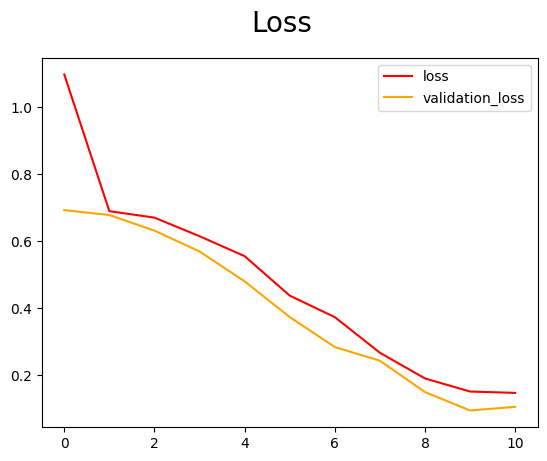

In [145]:
# plotting loss data
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'validation_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper right')
plt.show()

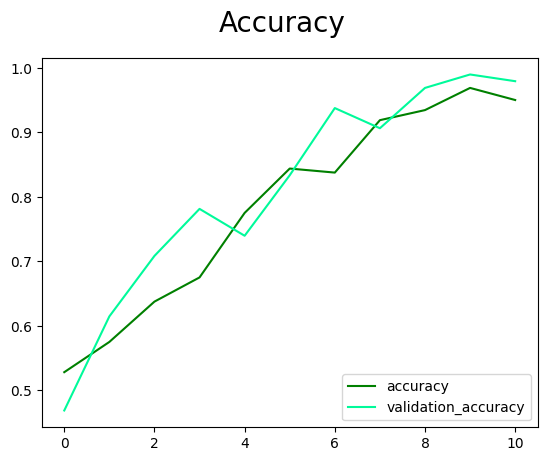

In [146]:
# plotting accuracy data
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'green', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'mediumspringgreen', label = 'validation_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'lower right')
plt.show()

### Final Evaluation

In [147]:
from keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
bacc = BinaryAccuracy()

# test model using final evalutaion images
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    bacc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Binary Accuracy:{bacc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Precision:0.9428571462631226, Recall:0.970588207244873, Binary Accuracy:0.953125


### Further Testing

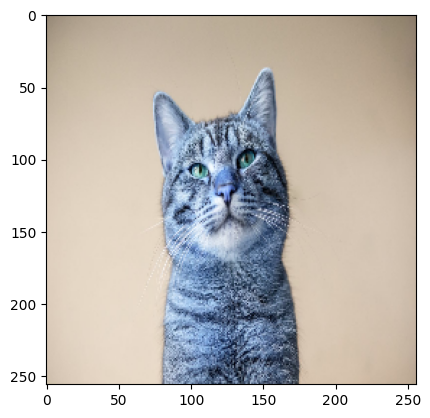

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
This image is predicted to be a cat!
[0.05216777]


In [148]:
import numpy as np
from keras.models import load_model

test_model = load_model(os.path.join('model', 'catsanddogs.keras'))

# read in a test image that the model has never seen before
img = cv2.imread('cattest.jpg')

# this the image resized to 256x256
# note, it is also in BGR not RGB but that does not affect the model's prediction
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = test_model.predict(np.expand_dims(resize/255, 0))

if yhat < .5:
    print('This image is predicted to be a cat!')
else:
    print('This image is predicted to be a dog!')

print(yhat[0])

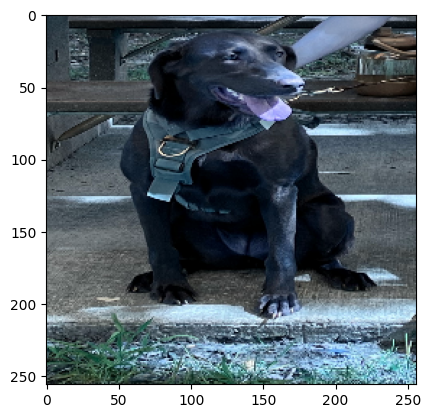

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
This image is predicted to be a dog!
[0.9996045]


In [149]:
img = cv2.imread('tobi.jpg')

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = test_model.predict(np.expand_dims(resize/255, 0))

if yhat < .5:
    print('This image is predicted to be a cat!')
else:
    print('This image is predicted to be a dog!')

print(yhat[0])

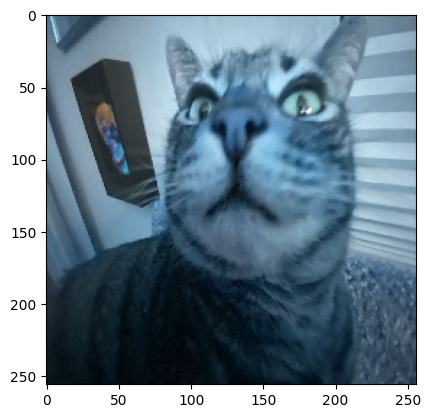

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image is predicted to be a cat!
[0.01856731]


In [150]:
img = cv2.imread('lucy.jpeg')

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = test_model.predict(np.expand_dims(resize/255, 0))

if yhat < .5:
    print('This image is predicted to be a cat!')
else:
    print('This image is predicted to be a dog!')

print(yhat[0])